## Importing all necessary Library

In [1]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api
import random

from nltk.corpus import stopwords
from wordcloud import WordCloud
from gensim.models import KeyedVectors
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, SimpleRNN, LSTM, Bidirectional, GRU, Dense, 
                                     Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Layer

# Change working directory
os.chdir(r"C:\Users\Prashast\OneDrive\Desktop\Purdue\Course\MOD 3\Machine Learning\Project")

# Enable inline plotting
%matplotlib inline

In [2]:
#######################################################################################################################################################

## Loading the dataset

In [3]:
# Load the training and test datasets from CSV files
tweets_data_train = pd.read_csv('train.csv')
tweets_data_test = pd.read_csv('test.csv')

In [4]:
#######################################################################################################################################################

## Data Cleaning

In [5]:
# Download NLTK stopwords and create a set
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean tweet text
def tweet_clean(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"https?://\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"[^A-Za-z' ]+", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    # text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text cleaning to the relevant columns
tweets_data_train['text_cleaned'] = tweets_data_train['text'].apply(tweet_clean)
tweets_data_test['text_cleaned'] = tweets_data_test['text'].apply(tweet_clean)
tweets_data_train['keyword_cleaned'] = tweets_data_train['keyword'].apply(lambda x: tweet_clean(str(x)))
tweets_data_test['keyword_cleaned'] = tweets_data_test['keyword'].apply(lambda x: tweet_clean(str(x)))

# Create a new 'combined_text' column by concatenating the cleaned keyword and text
tweets_data_train['combined_text'] = tweets_data_train['keyword_cleaned'] + " " + tweets_data_train['text_cleaned']
tweets_data_test['combined_text'] = tweets_data_test['keyword_cleaned'] + " " + tweets_data_test['text_cleaned']

# Extract features and labels
X_text = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

In [6]:
#######################################################################################################################################################

## Distribution of Target Variables in Training data

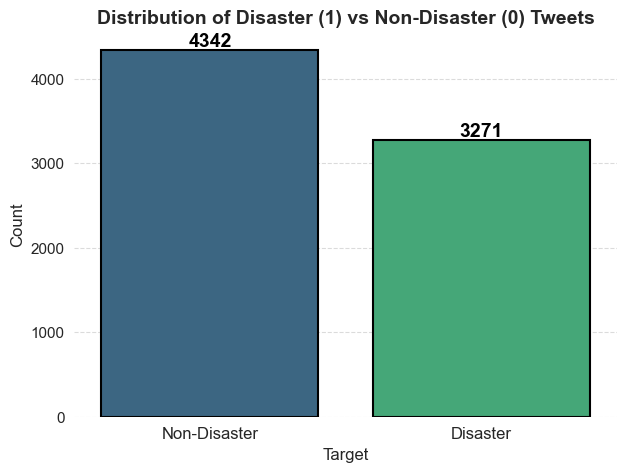

In [7]:
# Distribution of target labels
target_counts = tweets_data_train['target'].value_counts()

# Set Seaborn style
sns.set_style("whitegrid")

# Create figure and axis
plt.figure(figsize=(7,5))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, 
                 palette="viridis", legend=False, edgecolor="black", linewidth=1.5)

# Add labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', 
                fontsize=14, fontweight='bold', color='black')

# Customize appearance
plt.title("Distribution of Disaster (1) vs Non-Disaster (0) Tweets", fontsize=14, fontweight='bold')
plt.xlabel("Target", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'], fontsize=12)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Subtle grid
plt.box(False)  # Remove border for a clean look

# Show plot
plt.show()

In [8]:
#######################################################################################################################################################

## Word Cloud

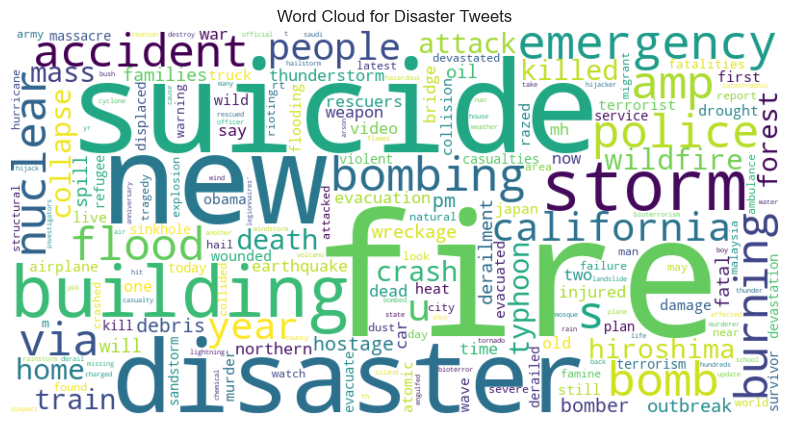

In [9]:
# Create a word cloud for Disaster tweets (target=1)
disaster_text = " ".join(tweets_data_train[tweets_data_train['target'] == 1]['combined_text'])
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(disaster_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Disaster Tweets")
plt.show()

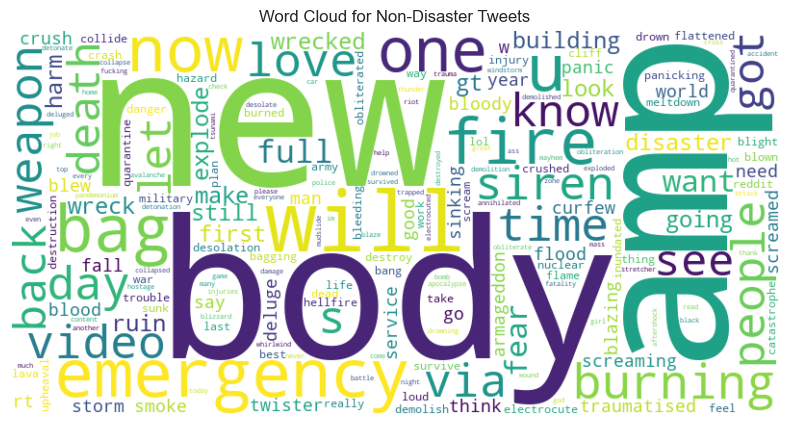

In [10]:
# Create a word cloud for Non-Disaster tweets (target=0)
non_disaster_text = " ".join(tweets_data_train[tweets_data_train['target'] == 0]['combined_text'])
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(non_disaster_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Non-Disaster Tweets")
plt.show()

In [11]:
#######################################################################################################################################################

## Vader Score

In [12]:
# Download the VADER lexicon for sentiment analysis.
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def get_vader_score(text):
    score = sia.polarity_scores(text)['compound']
    return (score + 1) / 2  # Normalize to [0,1]

tweets_data_train['vader_score'] = tweets_data_train['combined_text'].apply(get_vader_score)
tweets_data_test['vader_score'] = tweets_data_test['combined_text'].apply(get_vader_score)

# Select and keep only the necessary columns for further processing:
tweets_data_cleaned_train = tweets_data_train[['id', 'combined_text', 'vader_score', 'target']]
tweets_data_cleaned_test = tweets_data_test[['id', 'combined_text', 'vader_score']]

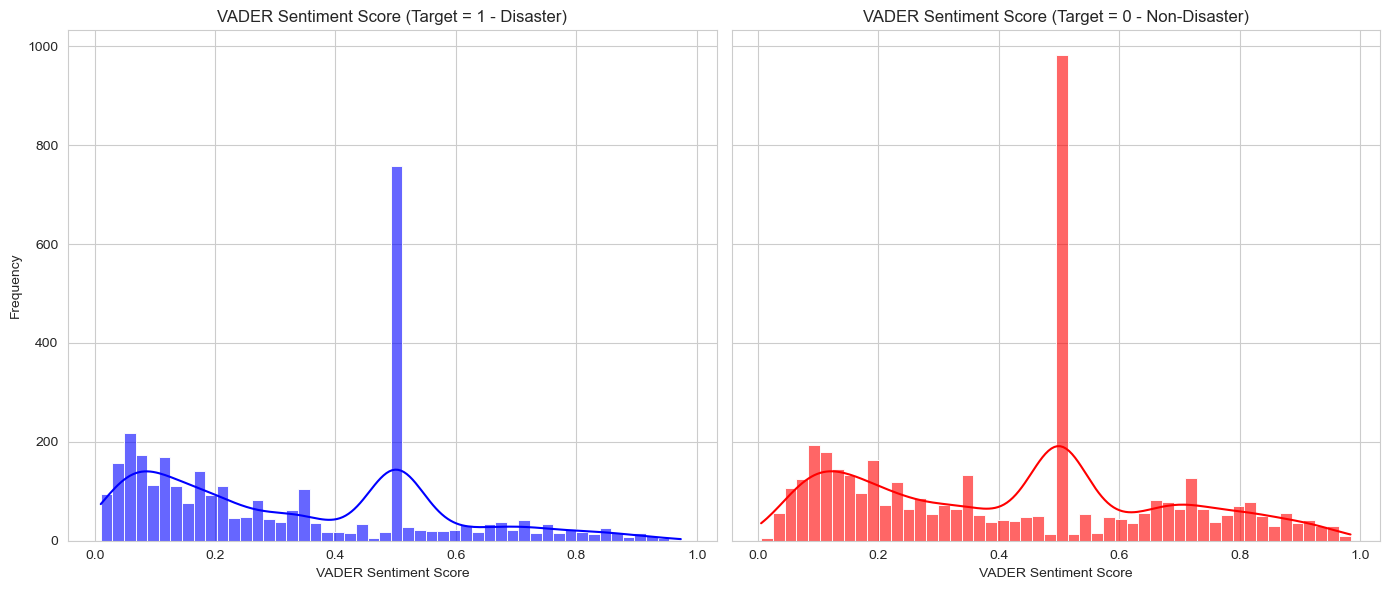

In [13]:
# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot VADER score distribution for target = 1 (disaster tweets)
sns.histplot(tweets_data_cleaned_train[tweets_data_cleaned_train['target'] == 1]['vader_score'], bins=50, color='blue', alpha=0.6, kde=True, ax=axes[0])
axes[0].set_title("VADER Sentiment Score (Target = 1 - Disaster)")
axes[0].set_xlabel("VADER Sentiment Score")
axes[0].set_ylabel("Frequency")

# Plot VADER score distribution for target = 0 (non-disaster tweets)
sns.histplot(tweets_data_cleaned_train[tweets_data_cleaned_train['target'] == 0]['vader_score'],
             bins=50, color='red', alpha=0.6, kde=True, ax=axes[1])
axes[1].set_title("VADER Sentiment Score (Target = 0 - Non-Disaster)")
axes[1].set_xlabel("VADER Sentiment Score")
axes[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
#######################################################################################################################################################

## Tokenizing the dataset

In [15]:
# Create and fit the tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_data_train['combined_text'])

# Total vocabulary size (including the OOV token)
vocab_size = len(tokenizer.word_index) + 1
print("Total vocabulary size:", vocab_size)

# Convert texts to sequences for training and test data
train_sequences = tokenizer.texts_to_sequences(tweets_data_train['combined_text'])
test_sequences = tokenizer.texts_to_sequences(tweets_data_test['combined_text'])

# Calculate maximum sequence length for each dataset
max_seq_train = max(len(seq) for seq in train_sequences)
max_seq_test = max(len(seq) for seq in test_sequences)

print("Maximum sequence length in training data:", max_seq_train)
print("Maximum sequence length in test data:", max_seq_test)

Total vocabulary size: 14776
Maximum sequence length in training data: 34
Maximum sequence length in test data: 33


In [16]:
#######################################################################################################################################################

## Loading Glove Twitter - 200 Embeddings

In [17]:
# Load or download the GloVe Twitter embeddings model
glove_path = r"C:\Users\Prashast\OneDrive\Desktop\Purdue\Course\MOD 3\Machine Learning\Project\glove-twitter-200.model"
if os.path.exists(glove_path):
    print("Loading GloVe Twitter model from local path...")
    glove_model = KeyedVectors.load(glove_path)
else:
    print("Downloading GloVe Twitter embeddings for the first time...")
    glove_model = api.load("glove-twitter-200")
    glove_model.save(glove_path)
    print("GloVe Twitter embeddings saved locally for future use.")

EMBEDDING_DIM = 200

Loading GloVe Twitter model from local path...


In [18]:
#######################################################################################################################################################

## Custom F1 Score Function

In [19]:
class F1ScoreCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data  # (X_train_seq, y_train)
        self.val_data = val_data      # (X_val_seq, y_val)
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        X_train_seq, y_train = self.train_data
        train_preds = self.model.predict(X_train_seq, verbose=0)
        train_pred_classes = (train_preds > 0.5).astype(int)
        train_f1 = f1_score(y_train, train_pred_classes)

        X_val_seq, y_val = self.val_data
        val_preds = self.model.predict(X_val_seq, verbose=0)
        val_pred_classes = (val_preds > 0.5).astype(int)
        val_f1 = f1_score(y_val, val_pred_classes)

        self.train_f1s.append(train_f1)
        self.val_f1s.append(val_f1)
        logs['f1'] = train_f1
        logs['val_f1'] = val_f1
        print(f" — train_f1: {train_f1:.4f} — val_f1: {val_f1:.4f}")

In [20]:
#######################################################################################################################################################

## Model Architectures

## Simple RNN

In [21]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Simple_RNN(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = SimpleRNN(64, dropout=0.5, recurrent_dropout=0.3)(text_branch)

    x = BatchNormalization()(text_branch)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Simple LSTM

In [22]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Simple_LSTM(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.3)(text_branch)

    x = BatchNormalization()(text_branch)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Simple GRU

In [23]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Simple_GRU(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = GRU(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.3)(text_branch)

    x = BatchNormalization()(text_branch)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Bi-Directional LSTM

In [24]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Bidirectional_LSTM(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = Bidirectional(LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.3))(text_branch)

    x = BatchNormalization()(text_branch)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Bi-Directional GRU

In [25]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Bidirectional_GRU(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = Bidirectional(GRU(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.3))(text_branch)

    x = BatchNormalization()(text_branch)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Stacked LSTM

In [26]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Stacked_LSTM(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(text_branch)
    text_branch = LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.3)(text_branch)
    
    #pooled_output = GlobalAveragePooling1D()(text_branch)

    x = BatchNormalization()(text_branch)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Stacked GRU

In [27]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Stacked_GRU(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = GRU(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(text_branch)
    text_branch = GRU(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.3)(text_branch)
    
    #pooled_output = GlobalAveragePooling1D()(text_branch)

    x = BatchNormalization()(text_branch)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Stacked Bi-directional LSTM

In [28]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Stacked_Bidirectional_LSTM(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.3))(text_branch)
    text_branch = Bidirectional(LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.3))(text_branch)
    
    pooled_output = GlobalAveragePooling1D()(text_branch)

    x = BatchNormalization()(pooled_output)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Stacked Bi-directional GRU

In [29]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Stacked_Bidirectional_GRU(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = Bidirectional(GRU(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.3))(text_branch)
    text_branch = Bidirectional(GRU(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.3))(text_branch)
    
    pooled_output = GlobalAveragePooling1D()(text_branch)

    x = BatchNormalization()(pooled_output)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

## Stacked Bi-Direcctional GRU With Attention

In [30]:
# Define Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        hidden_size = input_shape[-1]  # Extract last dimension
        self.W = self.add_weight(name="att_weight",
                                 shape=(hidden_size, hidden_size),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(hidden_size,),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(name="context_vector",
                                 shape=(hidden_size, 1),  # Change shape to (hidden_size, 1)
                                 initializer="random_normal",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # Compute hidden representation
        u_it = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)  # (batch_size, time_steps, hidden_size)
        
        # Compute attention scores (unnormalized)
        att_scores = tf.keras.backend.dot(u_it, self.u)  # (batch_size, time_steps, 1)

        # Reshape to (batch_size, time_steps)
        att_scores = tf.keras.backend.squeeze(att_scores, axis=-1)  

        # Normalize scores to get attention weights
        att_weights = tf.keras.backend.softmax(att_scores)  # (batch_size, time_steps)

        # Multiply each hidden state by its attention weight
        weighted_input = inputs * tf.keras.backend.expand_dims(att_weights, axis=-1)  # (batch_size, time_steps, hidden_size)

        # Sum the weighted hidden states to get context vector
        output = tf.keras.backend.sum(weighted_input, axis=1)  # (batch_size, hidden_size)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])  # Output shape is (batch_size, hidden_size)


def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def Stacked_Bidirectional_GRU_Attention(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,embedding_matrix, max_sequence_length,vocabulary_size, embedding_dim, max_epochs):
    
    set_seed(42)
    text_input = Input(shape=(max_sequence_length,), name="text_input")
    text_branch = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            trainable=True, embeddings_regularizer=l2(1e-3))(text_input)

    text_branch = Bidirectional(GRU(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.3))(text_branch)
    text_branch = Bidirectional(GRU(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.3))(text_branch)
    
    attention_output = AttentionLayer()(text_branch)

    x = BatchNormalization()(attention_output)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=text_input, outputs=output)

    # Compile the model with standard binary crossentropy loss
    loss_fn = BinaryCrossentropy()
    model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Compute class weights based on the training labels to handle imbalance
    classes = np.unique(train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
    print(f"Computed class weights for fold {fold_idx+1}, run {run_idx+1}: {class_weight_dict}")
    
    f1_callback = F1ScoreCallback(
        train_data=(train_padded_sequences, train_labels),
        val_data=(val_padded_sequences, val_labels)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(train_padded_sequences,
                        train_labels,
                        validation_data=(val_padded_sequences, val_labels),
                        epochs=max_epochs,
                        batch_size=32,
                        callbacks=[f1_callback, early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        verbose=1)

    # Compute and plot confusion matrix for the validation set
    val_predictions = model.predict(val_padded_sequences)
    val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

    return history.history

In [31]:
#######################################################################################################################################################

## Model Performance on Validation Set

## Simple RNN

In [32]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Simple_RNN(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Simple RNN logs.csv", index=False)
print("Combined log file 'Simple RNN logs.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4958 - loss: 514.6274 — train_f1: 0.1171 — val_f1: 0.1585
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4958 - loss: 514.2899 - val_accuracy: 0.5469 - val_loss: 336.0161 - f1: 0.1171 - val_f1: 0.1585 - learning_rate: 0.0010
Epoch 2/15
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4932 - loss: 297.2675 — train_f1: 0.3332 — val_f1: 0.3605
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4933 - loss: 296.9118 - val_accuracy: 0.5575 - val_loss: 202.4708 - f1: 0.3332 - val_f1: 0.3605 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4978 - loss: 181.0629 — train_f1: 0.0015 — val_f1: 0.0000
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4978 - loss: 180.9648 - val_accuracy: 0.5693 - val_loss: 128.2895 - f1: 0.00

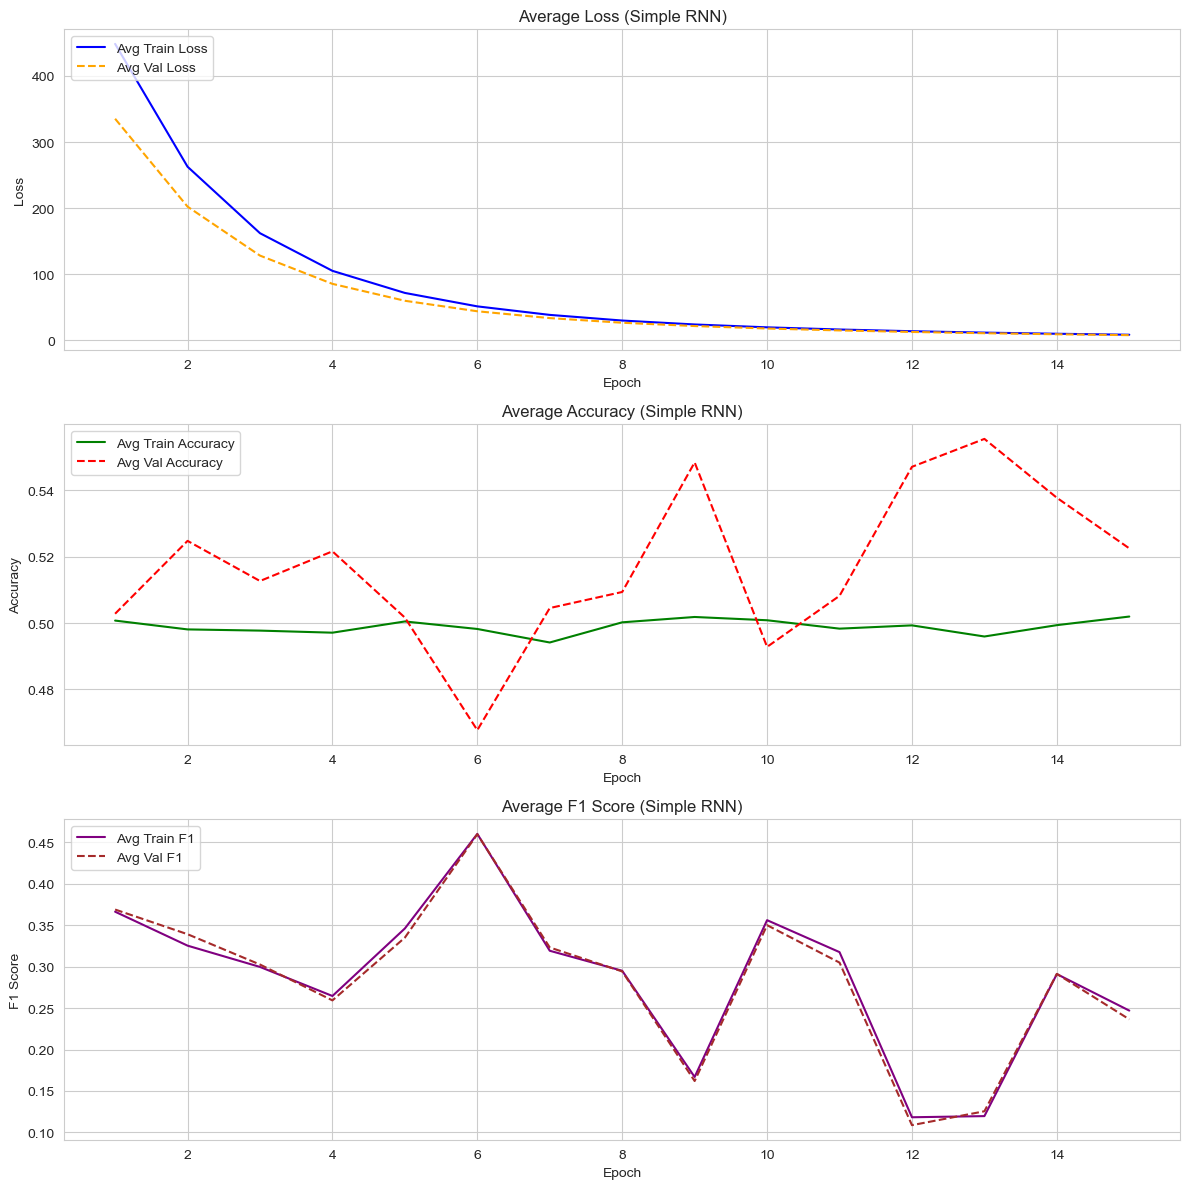

In [33]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Simple RNN)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Simple RNN)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Simple RNN)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
#######################################################################################################################################################

## Simple LSTM

In [35]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Simple_LSTM(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Simple LSTM logs.csv", index=False)
print("Combined log file 'Simple LSTM logs.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4937 - loss: 513.8637 — train_f1: 0.0000 — val_f1: 0.0030
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4937 - loss: 513.5217 - val_accuracy: 0.5706 - val_loss: 333.0407 - f1: 0.0000e+00 - val_f1: 0.0030 - learning_rate: 0.0010
Epoch 2/15
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5015 - loss: 294.1587 — train_f1: 0.5885 — val_f1: 0.4890
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.5016 - loss: 293.8027 - val_accuracy: 0.6940 - val_loss: 199.4676 - f1: 0.5885 - val_f1: 0.4890 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5952 - loss: 178.2208 — train_f1: 0.6921 — val_f1: 0.6132
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5954 - loss: 178.1237 - val_accuracy: 0.7466 - val_loss: 125.9789 - f1: 

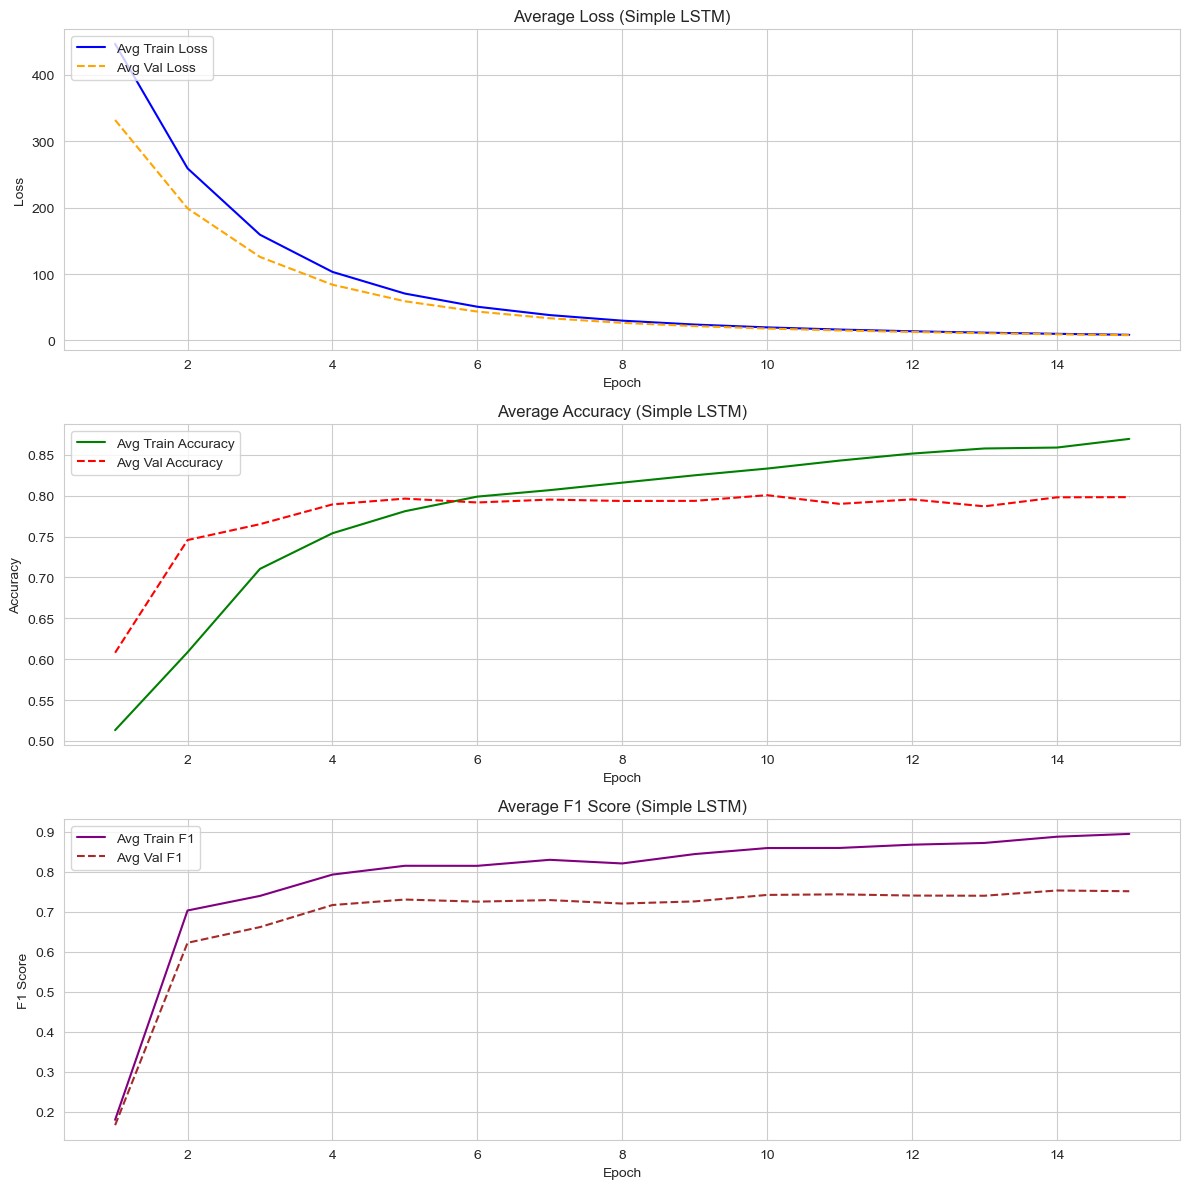

In [36]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Simple LSTM)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Simple LSTM)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Simple LSTM)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
#######################################################################################################################################################

## Simple GRU

In [38]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Simple_GRU(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Simple GRU logs.csv", index=False)
print("Combined log file 'Simple GRU logs.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5055 - loss: 514.2940 — train_f1: 0.0015 — val_f1: 0.0000
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5053 - loss: 513.2557 - val_accuracy: 0.5699 - val_loss: 332.4926 - f1: 0.0015 - val_f1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4838 - loss: 293.8393 — train_f1: 0.0091 — val_f1: 0.0121
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4839 - loss: 293.3040 - val_accuracy: 0.5712 - val_loss: 199.1335 - f1: 0.0091 - val_f1: 0.0121 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4903 - loss: 177.9590 — train_f1: 0.1859 — val_f1: 0.1795
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4903 - loss: 177.8621 - val_accuracy: 0.5318 - val_loss: 125.9125 - f1: 

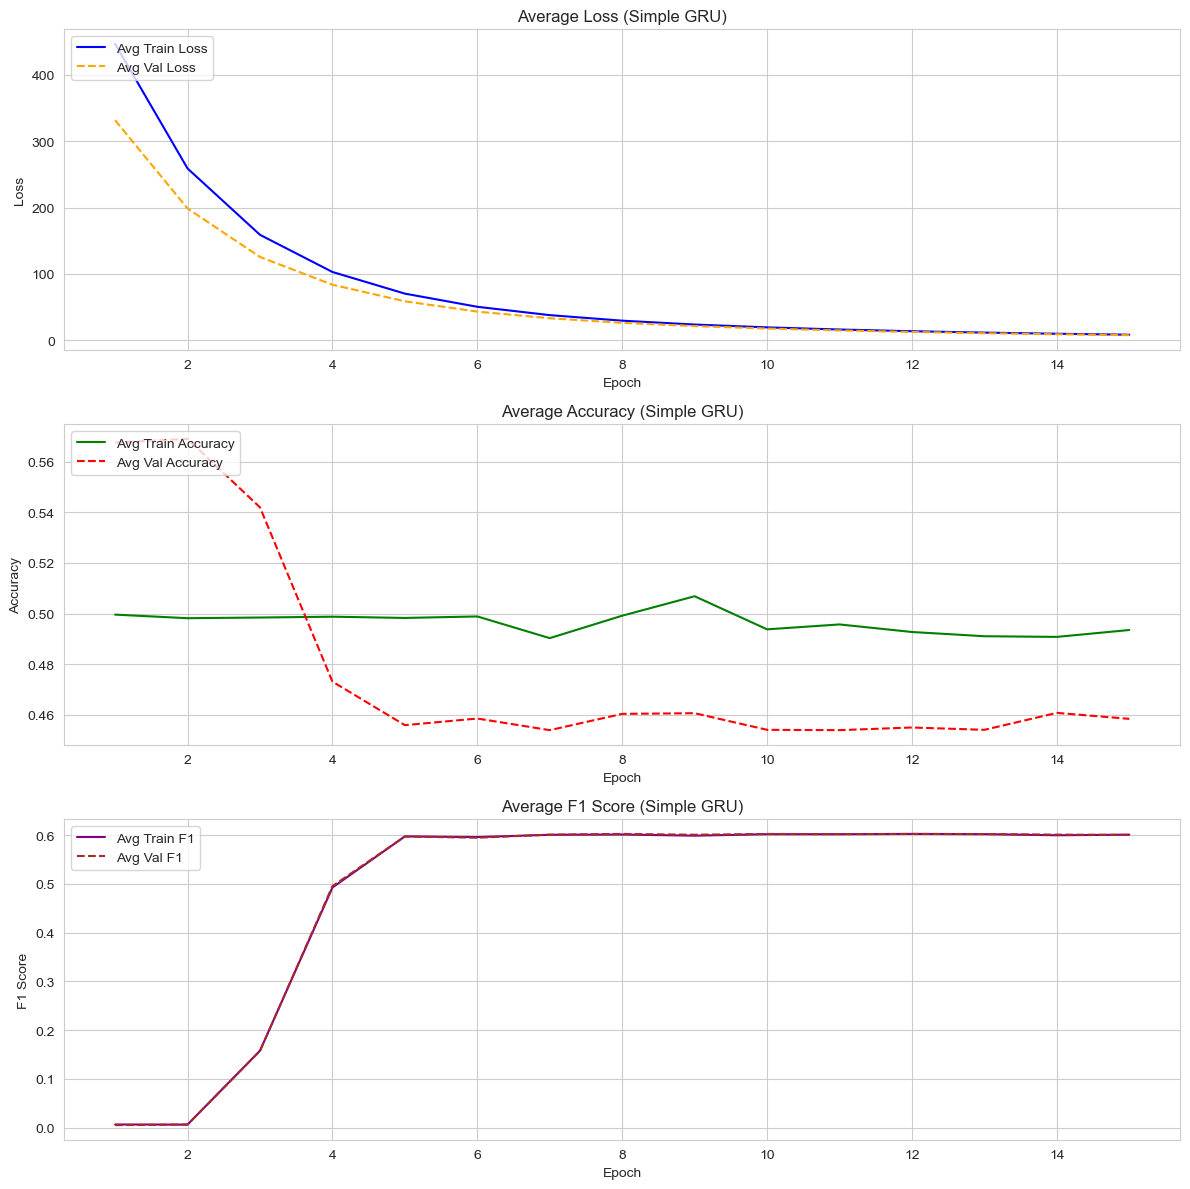

In [39]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Simple GRU)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Simple GRU)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Simple GRU)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
#######################################################################################################################################################

## Bi-Directional LSTM

In [41]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Bidirectional_LSTM(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Bidirectional LSTM logs.csv", index=False)
print("Combined log file 'Bidirectional LSTM logs.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5647 - loss: 514.1578 — train_f1: 0.6750 — val_f1: 0.6926
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.5649 - loss: 513.8169 - val_accuracy: 0.6527 - val_loss: 333.8938 - f1: 0.6750 - val_f1: 0.6926 - learning_rate: 0.0010
Epoch 2/15
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7004 - loss: 294.9630 — train_f1: 0.7562 — val_f1: 0.7624
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7006 - loss: 294.6070 - val_accuracy: 0.7807 - val_loss: 200.2020 - f1: 0.7562 - val_f1: 0.7624 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7528 - loss: 178.9702 — train_f1: 0.7911 — val_f1: 0.7524
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.7528 - loss: 178.8729 - val_accuracy: 0.8102 - val_loss: 126.5985 - f1: 0.

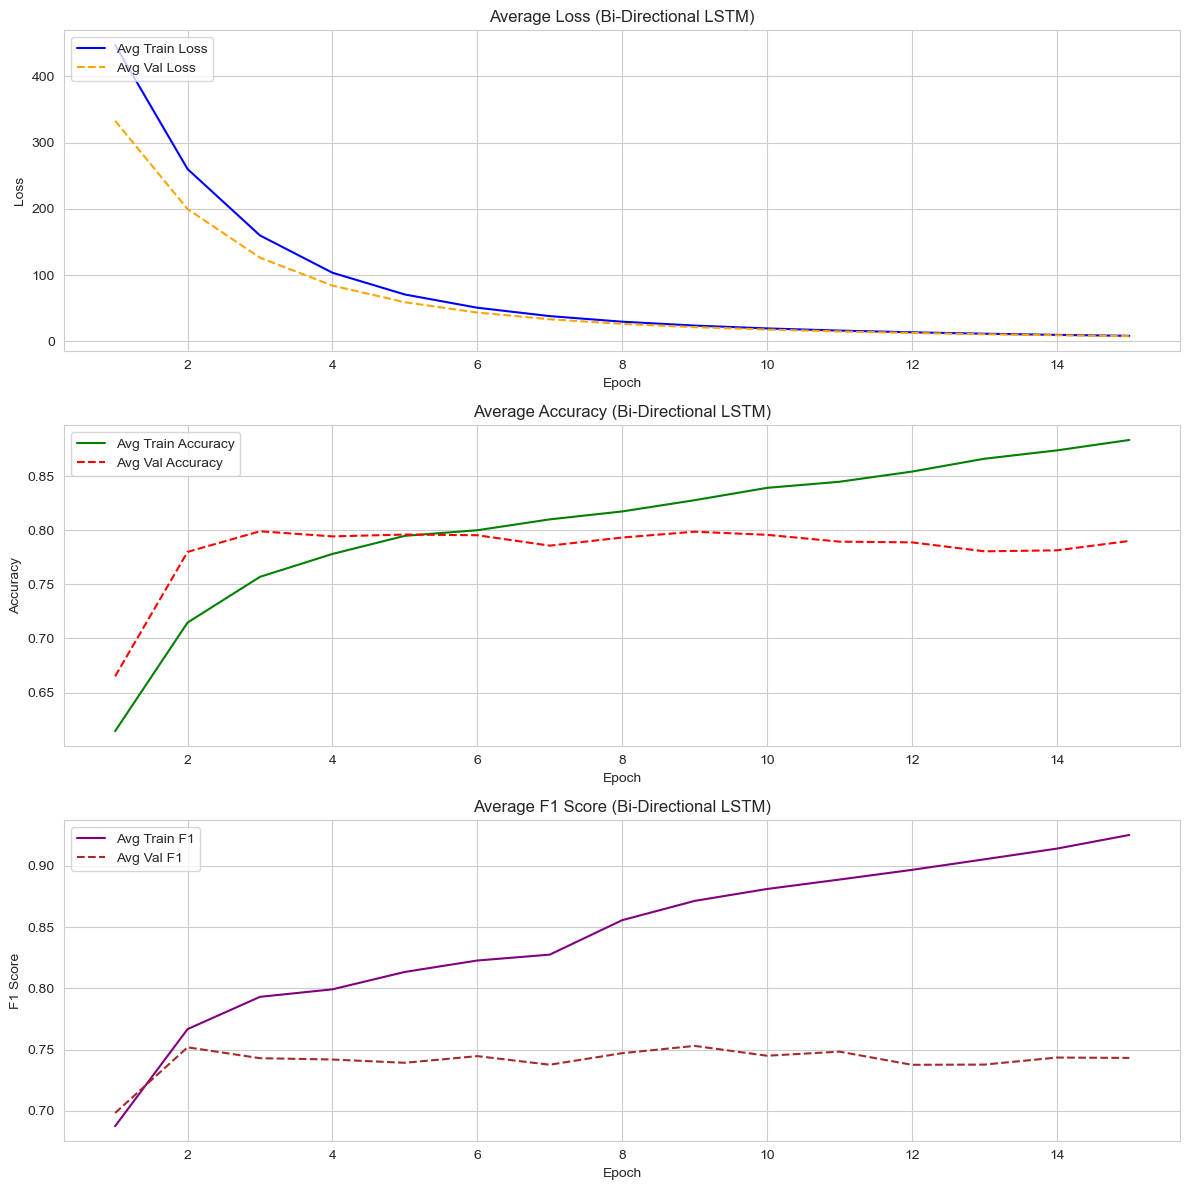

In [42]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Bi-Directional LSTM)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Bi-Directional LSTM)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Bi-Directional LSTM)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
#######################################################################################################################################################

## Bi-Directional GRU

In [44]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Bidirectional_GRU(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Bidirectional GRU logs.csv", index=False)
print("Combined log file 'Bidirectional GRU logs.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5646 - loss: 514.3810 — train_f1: 0.6766 — val_f1: 0.6858
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.5648 - loss: 513.6954 - val_accuracy: 0.6330 - val_loss: 333.7921 - f1: 0.6766 - val_f1: 0.6858 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6614 - loss: 294.7678 — train_f1: 0.7579 — val_f1: 0.7611
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.6615 - loss: 294.5910 - val_accuracy: 0.7919 - val_loss: 200.2522 - f1: 0.7579 - val_f1: 0.7611 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7173 - loss: 179.0765 — train_f1: 0.7794 — val_f1: 0.7412
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7174 - loss: 178.9792 - val_accuracy: 0.7978 - val_loss: 126.6932 - f1: 0.

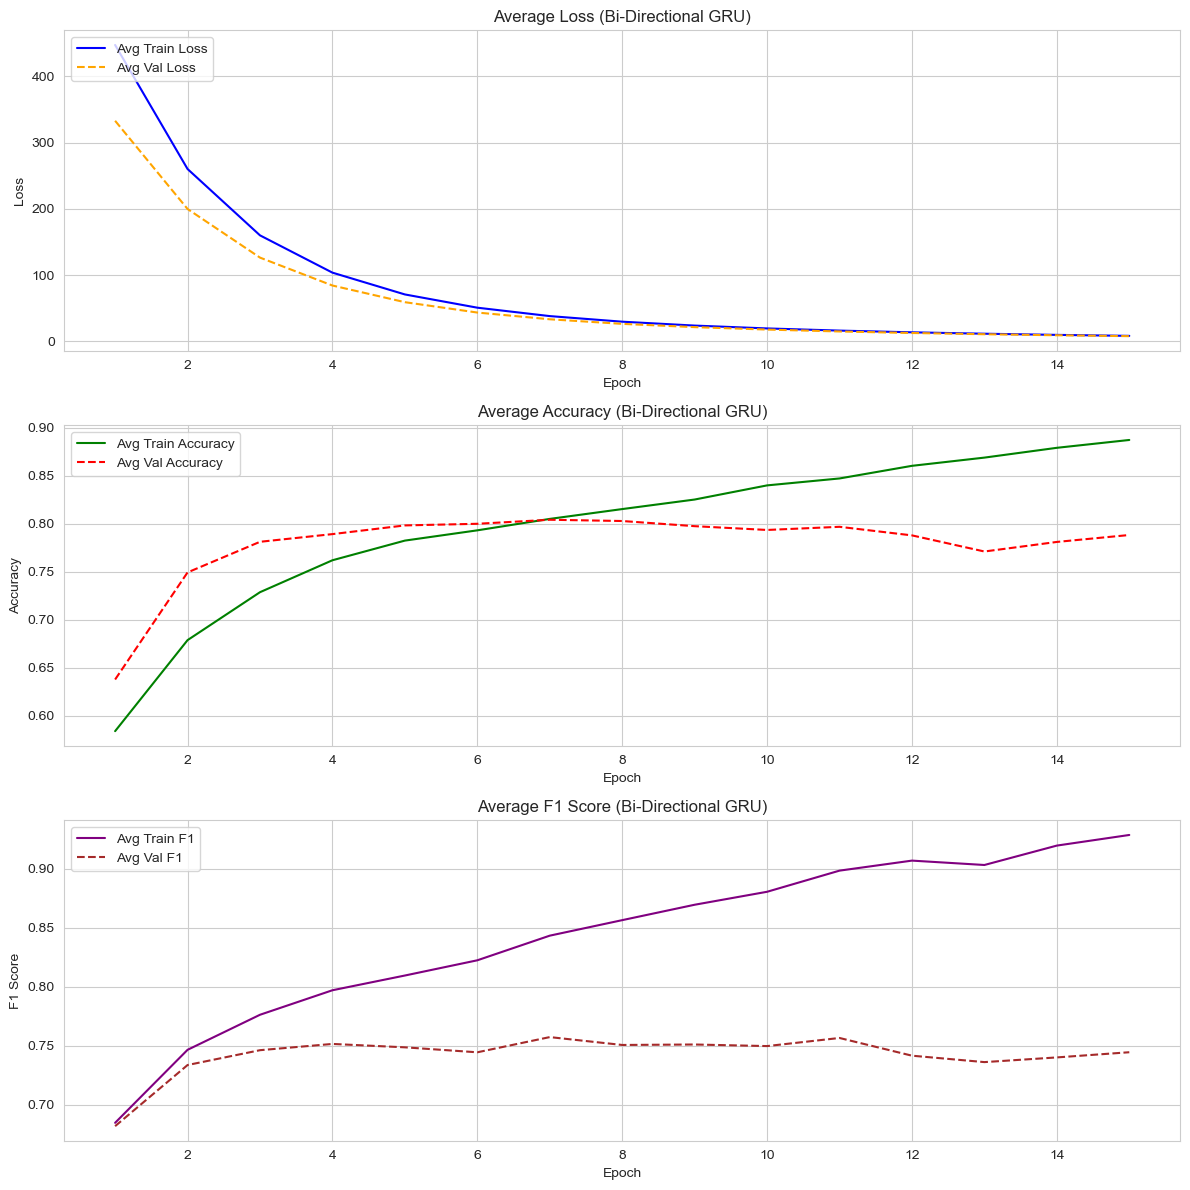

In [45]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Bi-Directional GRU)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Bi-Directional GRU)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Bi-Directional GRU)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [46]:
#######################################################################################################################################################

## Stacked LSTM

In [47]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Stacked_LSTM(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Stacked LSTM.csv", index=False)
print("Combined log file 'Stacked LSTM.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5383 - loss: 513.9761 — train_f1: 0.6412 — val_f1: 0.6447
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.5385 - loss: 513.6338 - val_accuracy: 0.5463 - val_loss: 333.0973 - f1: 0.6412 - val_f1: 0.6447 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6693 - loss: 293.9993 — train_f1: 0.7678 — val_f1: 0.7618
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.6693 - loss: 293.8225 - val_accuracy: 0.8037 - val_loss: 199.4876 - f1: 0.7678 - val_f1: 0.7618 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7267 - loss: 178.3851 — train_f1: 0.7889 — val_f1: 0.7654
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.7267 - loss: 178.2881 - val_accuracy: 0.8024 - val_loss: 126.1795 - f1: 0

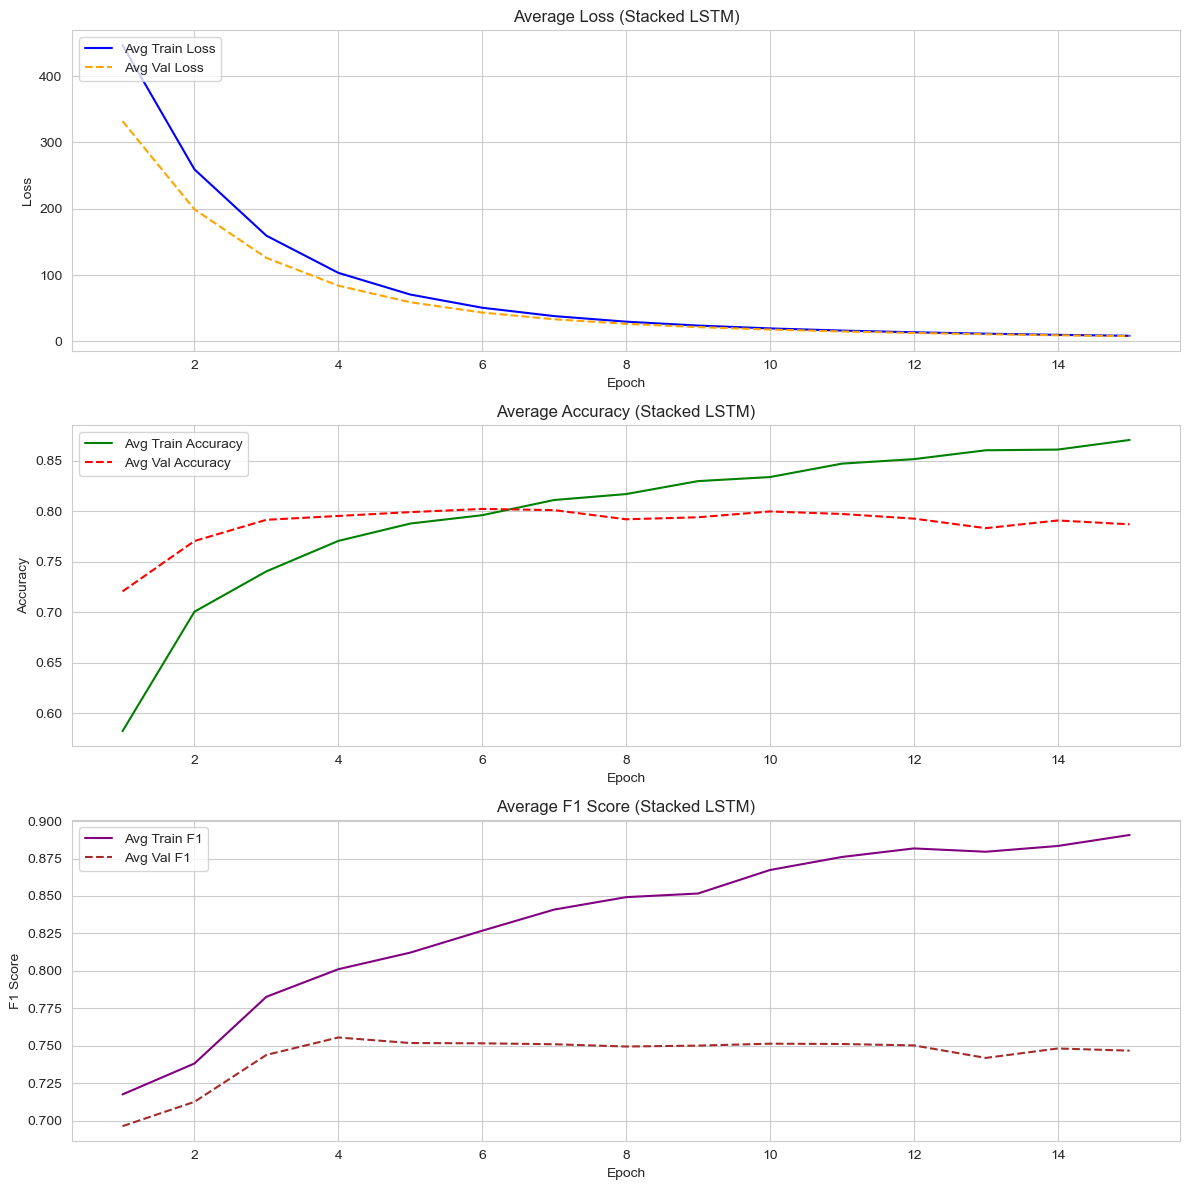

In [48]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Stacked LSTM)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Stacked LSTM)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Stacked LSTM)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [49]:
#######################################################################################################################################################

## Stacked GRU

In [50]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Stacked_GRU(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Stacked GRU.csv", index=False)
print("Combined log file 'Stacked GRU.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5177 - loss: 513.7320 — train_f1: 0.6014 — val_f1: 0.6011
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.5177 - loss: 513.3892 - val_accuracy: 0.4301 - val_loss: 332.6158 - f1: 0.6014 - val_f1: 0.6011 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5074 - loss: 293.5786 — train_f1: 0.6011 — val_f1: 0.6014
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.5074 - loss: 293.4018 - val_accuracy: 0.4307 - val_loss: 199.2127 - f1: 0.6011 - val_f1: 0.6014 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4902 - loss: 178.0185 — train_f1: 0.6014 — val_f1: 0.6045
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.4902 - loss: 177.9216 - val_accuracy: 0.4655 - val_loss: 125.9529 - f1: 0.

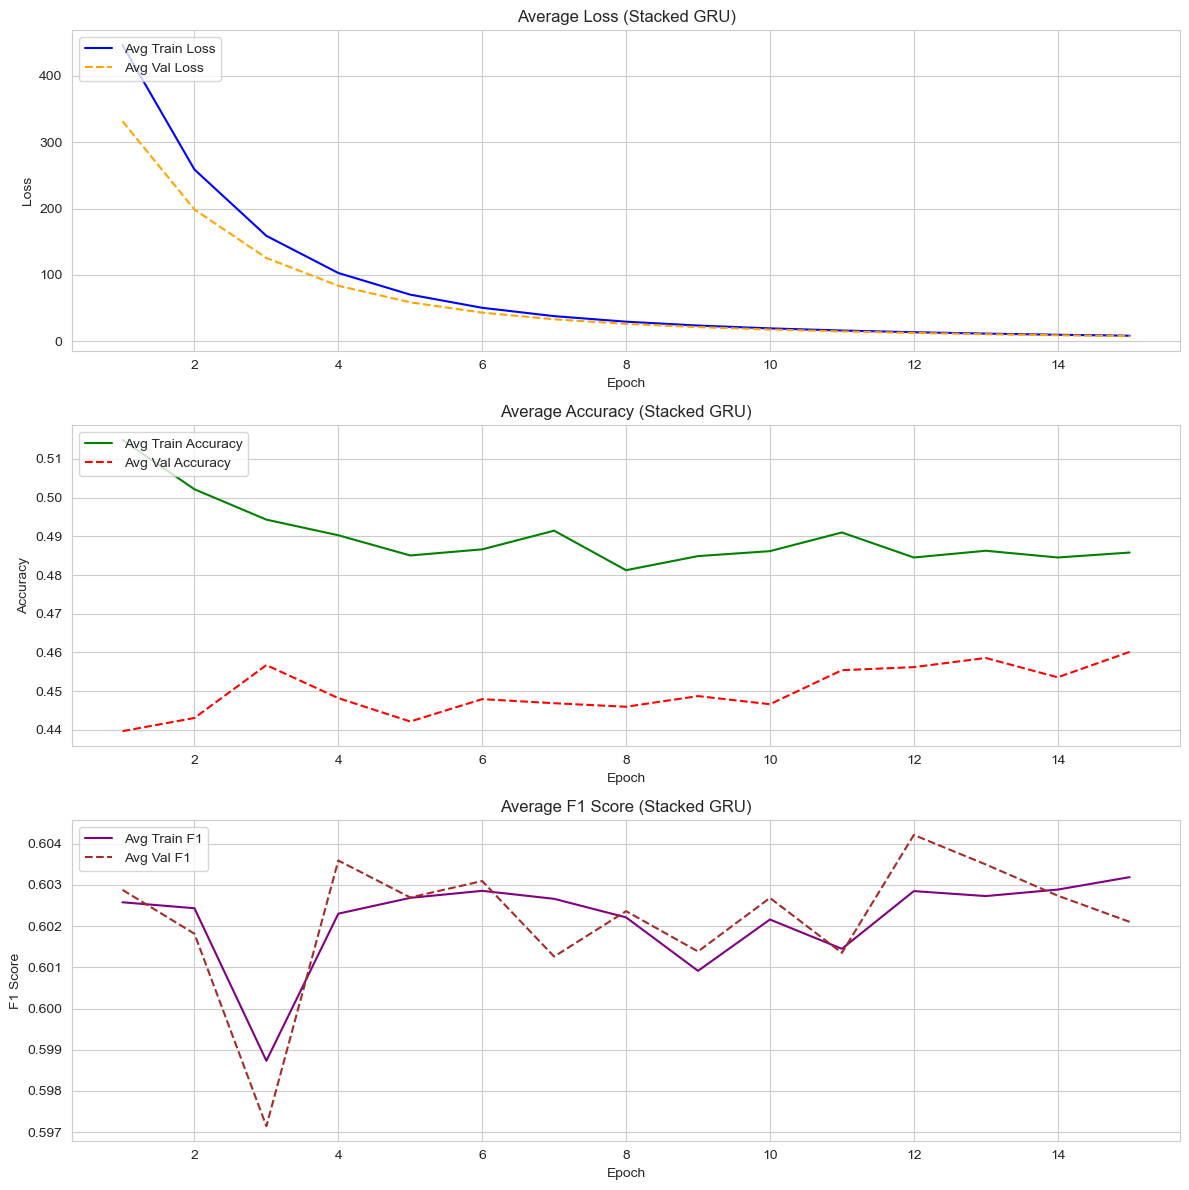

In [51]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Stacked GRU)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Stacked GRU)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Stacked GRU)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [52]:
#######################################################################################################################################################

## Stacked Bi-Directional LSTM

In [53]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Stacked_Bidirectional_LSTM(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Stacked Bidirectional LSTM.csv", index=False)
print("Combined log file 'Stacked Bidirectional LSTM.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5881 - loss: 513.8865 — train_f1: 0.7265 — val_f1: 0.7466
191/191 ━━━━━━━━━━━━━━━━━━━━ 52s 174ms/step - accuracy: 0.5883 - loss: 513.5441 - val_accuracy: 0.7557 - val_loss: 332.9416 - f1: 0.7265 - val_f1: 0.7466 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7233 - loss: 293.8546 — train_f1: 0.7719 — val_f1: 0.7632
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - accuracy: 0.7233 - loss: 293.6777 - val_accuracy: 0.7938 - val_loss: 199.3766 - f1: 0.7719 - val_f1: 0.7632 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7636 - loss: 178.2307 — train_f1: 0.7906 — val_f1: 0.7254
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.7636 - loss: 178.1337 - val_accuracy: 0.7951 - val_loss: 126.1009 - f

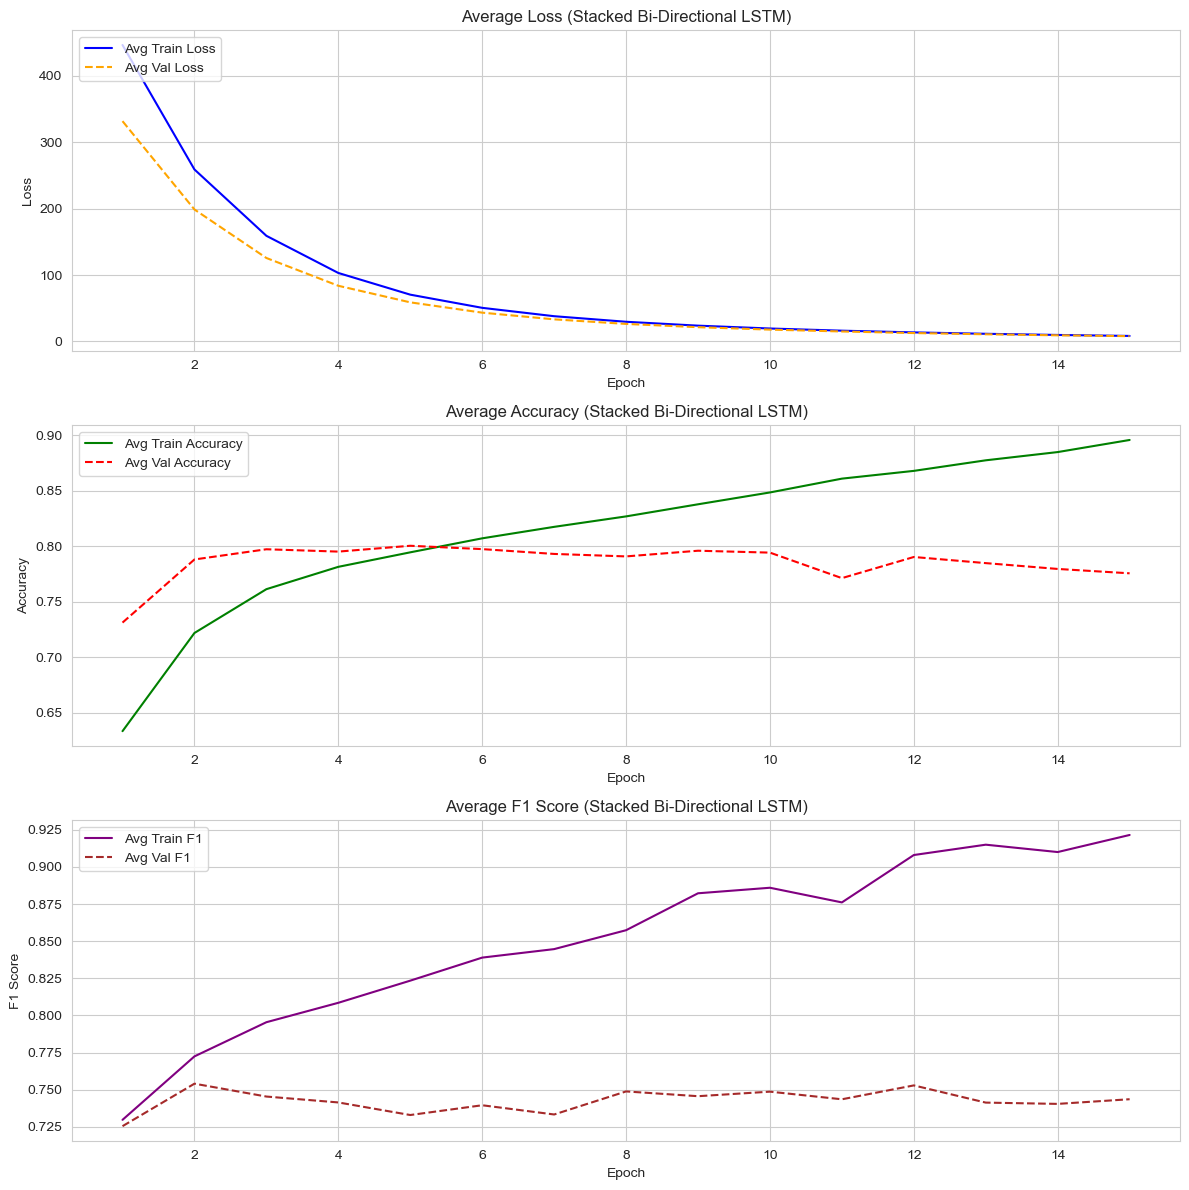

In [54]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Stacked Bi-Directional LSTM)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Stacked Bi-Directional LSTM)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Stacked Bi-Directional LSTM)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [55]:
#######################################################################################################################################################

## Stacked Bi-Directional GRU

In [56]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Stacked_Bidirectional_GRU(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Stacked Bidirectional GRU.csv", index=False)
print("Combined log file 'Stacked Bidirectional GRU.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6078 - loss: 513.8157 — train_f1: 0.7278 — val_f1: 0.7534
191/191 ━━━━━━━━━━━━━━━━━━━━ 60s 208ms/step - accuracy: 0.6080 - loss: 513.4733 - val_accuracy: 0.7610 - val_loss: 332.8459 - f1: 0.7278 - val_f1: 0.7534 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7254 - loss: 293.7738 — train_f1: 0.7628 — val_f1: 0.7630
191/191 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.7254 - loss: 293.5970 - val_accuracy: 0.7879 - val_loss: 199.3306 - f1: 0.7628 - val_f1: 0.7630 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7582 - loss: 178.1829 — train_f1: 0.8015 — val_f1: 0.7562
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 182ms/step - accuracy: 0.7583 - loss: 178.0860 - val_accuracy: 0.8129 - val_loss: 126.0544 - 

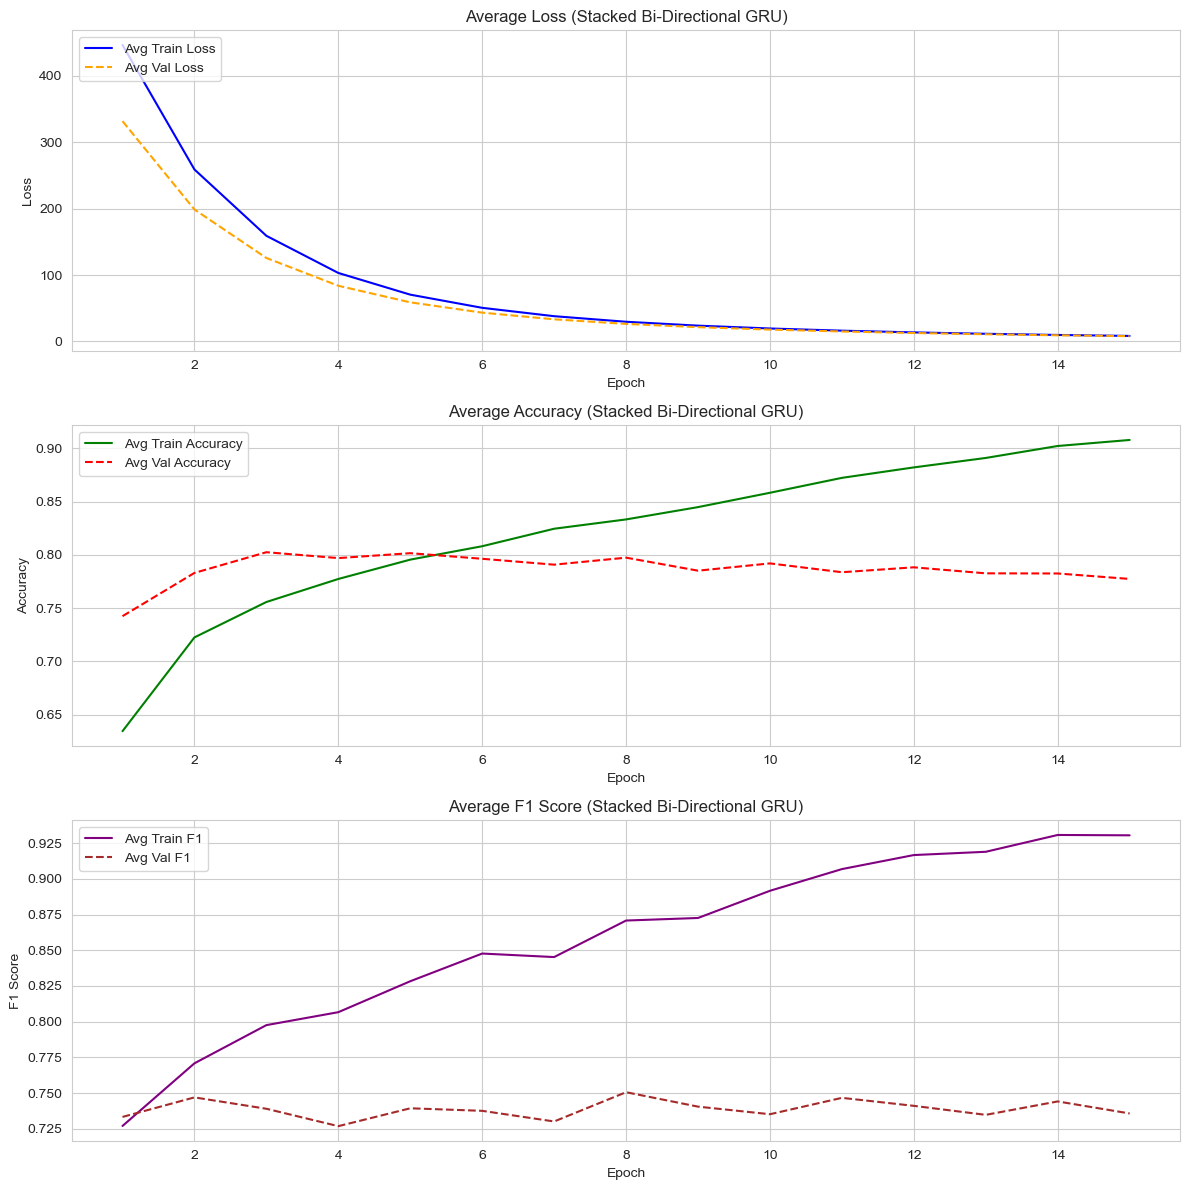

In [57]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Stacked Bi-Directional GRU)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Stacked Bi-Directional GRU)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Stacked Bi-Directional GRU)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [58]:
#######################################################################################################################################################

## Stacked Bi-Directional GRU with Attention

In [59]:
# -------------------------
# CROSS-VALIDATION TRAINING SETUP & LOGGING ARRAYS
# -------------------------
NUM_FOLDS = 5
NUM_RUNS_PER_FOLD = 1
MAX_EPOCHS = 15

# Initialize logging arrays
actual_epochs_record = np.zeros((NUM_FOLDS, NUM_RUNS_PER_FOLD), dtype=int)
train_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_loss_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_accuracy_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
train_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]
val_f1_all_folds = [[[] for _ in range(NUM_RUNS_PER_FOLD)] for _ in range(NUM_FOLDS)]

X = tweets_data_train['combined_text']
y = tweets_data_train['target'].values

stratified_kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    print(f"\n=== Processing Fold {fold_idx+1}/{NUM_FOLDS} ===")
    
    train_texts = X.iloc[train_indices]
    train_labels = y[train_indices]
    val_texts = X.iloc[val_indices]
    val_labels = y[val_indices]
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    
    max_sequence_length = max((len(seq) for seq in (train_sequences + val_sequences) if seq), default=1)
    vocabulary_size = len(tokenizer.word_index) + 1
    
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Build embedding matrix from the glove_model
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if word in glove_model.key_to_index:
            embedding_matrix[index] = glove_model[word]
        else:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
    
    for run_idx in range(NUM_RUNS_PER_FOLD):
        print(f"--- Fold {fold_idx+1}, Run {run_idx+1} ---")
        history = Stacked_Bidirectional_GRU_Attention(fold_idx, run_idx,train_padded_sequences, train_labels,val_padded_sequences, val_labels,
                                   embedding_matrix, max_sequence_length,vocabulary_size, EMBEDDING_DIM, MAX_EPOCHS)
        # Log metrics from this run
        epochs_run = len(history['loss'])
        actual_epochs_record[fold_idx, run_idx] = epochs_run
        train_loss_all_folds[fold_idx][run_idx] = history['loss']
        train_accuracy_all_folds[fold_idx][run_idx] = history['accuracy']
        train_f1_all_folds[fold_idx][run_idx] = history.get('f1', [])
        val_loss_all_folds[fold_idx][run_idx] = history['val_loss']
        val_accuracy_all_folds[fold_idx][run_idx] = history['val_accuracy']
        val_f1_all_folds[fold_idx][run_idx] = history.get('val_f1', [])

# -------------------------
# AGGREGATE METRICS ACROSS RUNS & EPOCHS
# -------------------------
max_epochs_completed = int(actual_epochs_record.max())
average_train_loss = []
average_val_loss = []
average_train_accuracy = []
average_val_accuracy = []
average_train_f1 = []
average_val_f1 = []
epoch_contributions = []

for epoch in range(max_epochs_completed):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    epoch_train_f1s = []
    epoch_val_f1s = []
    
    for fold in range(NUM_FOLDS):
        for run in range(NUM_RUNS_PER_FOLD):
            if actual_epochs_record[fold, run] > epoch:
                epoch_train_losses.append(train_loss_all_folds[fold][run][epoch])
                epoch_val_losses.append(val_loss_all_folds[fold][run][epoch])
                epoch_train_accuracies.append(train_accuracy_all_folds[fold][run][epoch])
                epoch_val_accuracies.append(val_accuracy_all_folds[fold][run][epoch])
                epoch_train_f1s.append(train_f1_all_folds[fold][run][epoch])
                epoch_val_f1s.append(val_f1_all_folds[fold][run][epoch])
    
    if epoch_train_losses:
        average_train_loss.append(np.mean(epoch_train_losses))
        average_val_loss.append(np.mean(epoch_val_losses))
        average_train_accuracy.append(np.mean(epoch_train_accuracies))
        average_val_accuracy.append(np.mean(epoch_val_accuracies))
        average_train_f1.append(np.mean(epoch_train_f1s))
        average_val_f1.append(np.mean(epoch_val_f1s))
        epoch_contributions.append(len(epoch_train_losses))
    else:
        average_train_loss.append(np.nan)
        average_val_loss.append(np.nan)
        average_train_accuracy.append(np.nan)
        average_val_accuracy.append(np.nan)
        average_train_f1.append(np.nan)
        average_val_f1.append(np.nan)
        epoch_contributions.append(0)

epoch_range = range(1, max_epochs_completed + 1)
#for epoch, count in zip(epoch_range, epoch_contributions):
    #print(f"Epoch {epoch}: {count} runs contributed to the average.")

# -------------------------
# COMBINE ALL RUN LOGS INTO A SINGLE CSV FILE
# -------------------------
all_run_logs = []
for fold in range(NUM_FOLDS):
    for run in range(NUM_RUNS_PER_FOLD):
        epochs_run = actual_epochs_record[fold, run]
        for epoch in range(epochs_run):
            log_entry = {
                "fold": fold + 1,
                "run": run + 1,
                "epoch": epoch + 1,
                "train_loss": train_loss_all_folds[fold][run][epoch],
                "train_accuracy": train_accuracy_all_folds[fold][run][epoch],
                "train_f1": train_f1_all_folds[fold][run][epoch],
                "val_loss": val_loss_all_folds[fold][run][epoch],
                "val_accuracy": val_accuracy_all_folds[fold][run][epoch],
                "val_f1": val_f1_all_folds[fold][run][epoch],
            }
            all_run_logs.append(log_entry)

logs_dataframe = pd.DataFrame(all_run_logs)
logs_dataframe.to_csv("Stacked Bidirectional GRU - Attention.csv", index=False)
print("Combined log file 'Stacked Bidirectional GRU - Attention.csv' saved.")


=== Processing Fold 1/5 ===
--- Fold 1, Run 1 ---
Computed class weights for fold 1, run 1: {0: 0.8765112262521589, 1: 1.1639908256880733}
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5623 - loss: 514.0013 — train_f1: 0.7413 — val_f1: 0.7530
191/191 ━━━━━━━━━━━━━━━━━━━━ 65s 233ms/step - accuracy: 0.5626 - loss: 513.6595 - val_accuracy: 0.7682 - val_loss: 333.2152 - f1: 0.7413 - val_f1: 0.7530 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7056 - loss: 294.1854 — train_f1: 0.7843 — val_f1: 0.7706
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 206ms/step - accuracy: 0.7057 - loss: 294.0084 - val_accuracy: 0.8135 - val_loss: 199.6175 - f1: 0.7843 - val_f1: 0.7706 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7530 - loss: 178.4698 — train_f1: 0.8003 — val_f1: 0.7679
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 202ms/step - accuracy: 0.7530 - loss: 178.3727 - val_accuracy: 0.8194 - val_loss: 126.2402 - 

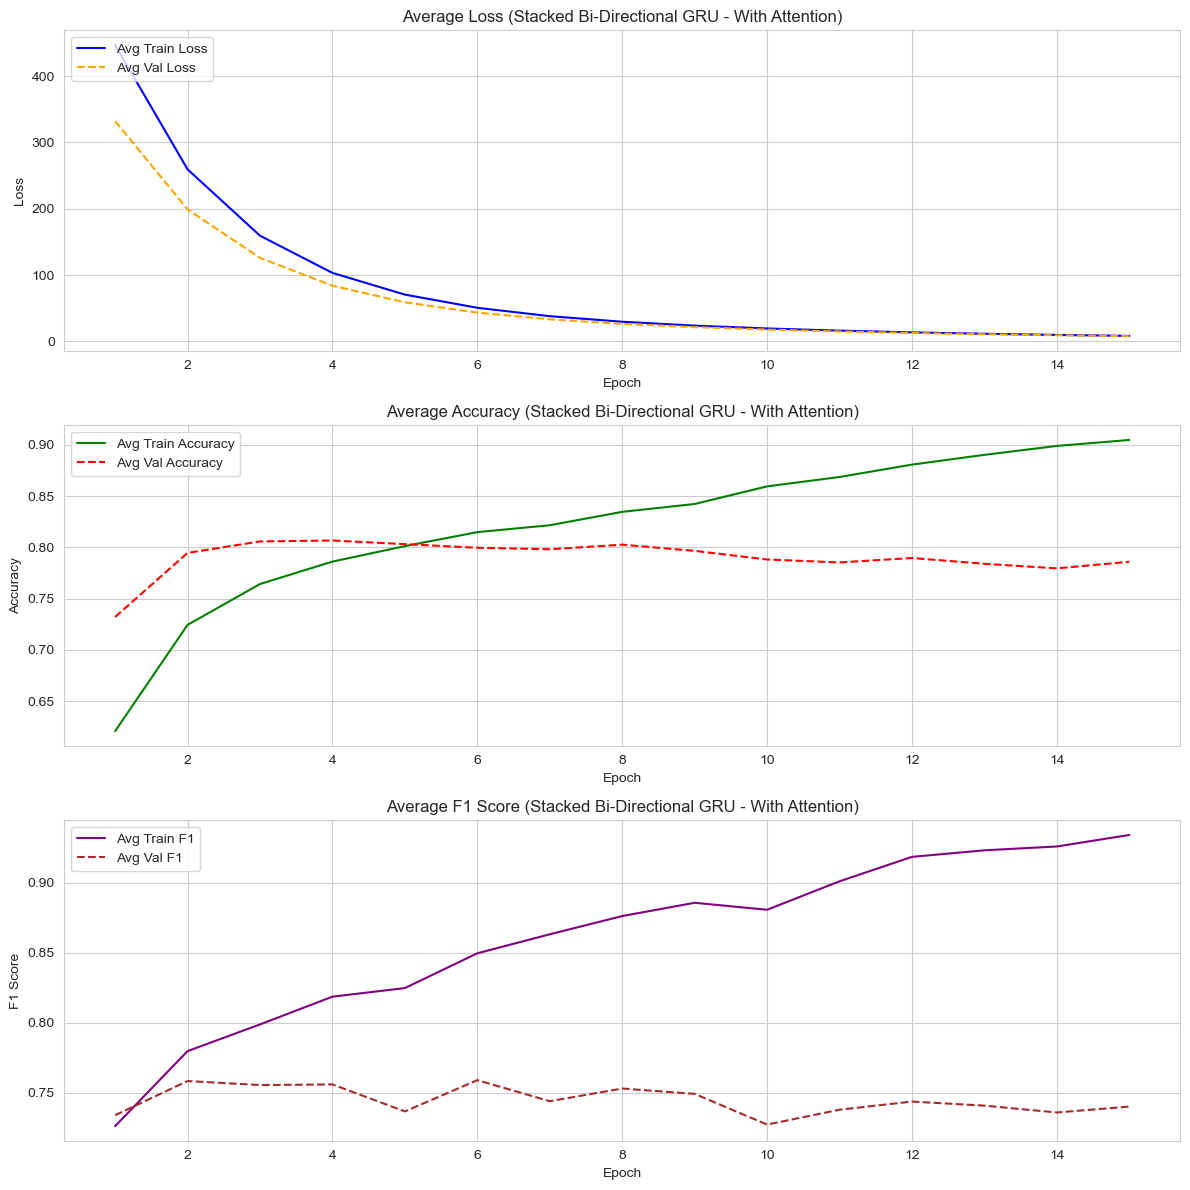

In [60]:
plt.figure(figsize=(12, 12))

# ---------------------------
# Loss Plot with Run Count
# ---------------------------
ax1 = plt.subplot(3, 1, 1)
ax1.plot(epoch_range, average_train_loss, label='Avg Train Loss', color='blue')
ax1.plot(epoch_range, average_val_loss, label='Avg Val Loss', linestyle='dashed', color='orange')
ax1.set_title('Average Loss (Stacked Bi-Directional GRU - With Attention)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# ---------------------------
# Accuracy Plot with Run Count
# ---------------------------
ax2 = plt.subplot(3, 1, 2)
ax2.plot(epoch_range, average_train_accuracy, label='Avg Train Accuracy', color='green')
ax2.plot(epoch_range, average_val_accuracy, label='Avg Val Accuracy', linestyle='dashed', color='red')
ax2.set_title('Average Accuracy (Stacked Bi-Directional GRU - With Attention)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

# ---------------------------
# F1 Score Plot with Run Count
# ---------------------------
ax3 = plt.subplot(3, 1, 3)
ax3.plot(epoch_range, average_train_f1, label='Avg Train F1', color='purple')
ax3.plot(epoch_range, average_val_f1, label='Avg Val F1', linestyle='dashed', color='brown')
ax3.set_title('Average F1 Score (Stacked Bi-Directional GRU - With Attention)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Step 5: Making Final Predictions on Test dataset (Majority Voting)

Computed class weights: {0: 0.8766697374481806, 1: 1.1637114032405993}

--- Final Model Run 1/5 ---
Epoch 1/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 167s 492ms/step - accuracy: 0.5694 - loss: 0.8390
Epoch 2/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 130s 545ms/step - accuracy: 0.7458 - loss: 0.6022
Epoch 3/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 130s 545ms/step - accuracy: 0.7984 - loss: 0.5496
Epoch 4/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 126s 530ms/step - accuracy: 0.8260 - loss: 0.4909
238/238 ━━━━━━━━━━━━━━━━━━━━ 67s 249ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step

--- Final Model Run 2/5 ---
Epoch 1/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 183s 554ms/step - accuracy: 0.5694 - loss: 0.8390
Epoch 2/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 127s 532ms/step - accuracy: 0.7458 - loss: 0.6022
Epoch 3/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 129s 543ms/step - accuracy: 0.7984 - loss: 0.5496
Epoch 4/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 128s 539ms/step - accuracy: 0.8260 - loss: 0.4909
238/238 ━━━━━━━━━━━━━━━━━━━━ 65s 249ms/step
102/102 ━━━━━━━━━━━━━━━━━━━

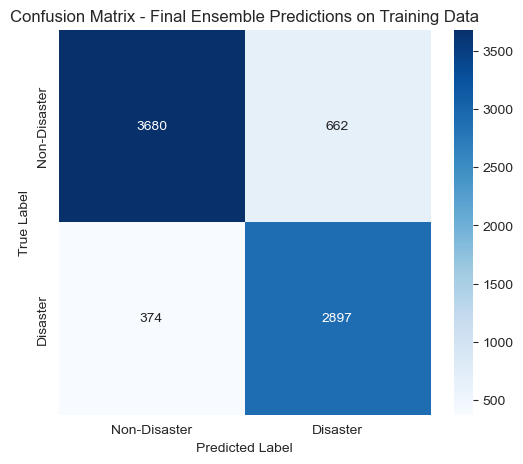

Final F1 score on training data: 0.8483

Final averaged probabilities on test data: [0.95987934 0.93253744 0.92696196 ... 0.98280126 0.98141676 0.810148  ]
Final binary predictions on test data: [1 1 1 ... 1 1 1]

Final submission file saved as 'final_submission.csv'.


In [61]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        hidden_size = input_shape[-1]  # Extract last dimension
        self.W = self.add_weight(name="att_weight",
                                 shape=(hidden_size, hidden_size),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(hidden_size,),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(name="context_vector",
                                 shape=(hidden_size, 1),  # Change shape to (hidden_size, 1)
                                 initializer="random_normal",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # Compute hidden representation
        u_it = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, time_steps, hidden_size)
        
        # Compute attention scores (unnormalized)
        att_scores = K.dot(u_it, self.u)  # (batch_size, time_steps, 1)

        # Reshape to (batch_size, time_steps)
        att_scores = K.squeeze(att_scores, axis=-1)  

        # Normalize scores to get attention weights
        att_weights = K.softmax(att_scores)  # (batch_size, time_steps)

        # Multiply each hidden state by its attention weight
        weighted_input = inputs * K.expand_dims(att_weights, axis=-1)  # (batch_size, time_steps, hidden_size)

        # Sum the weighted hidden states to get context vector
        output = K.sum(weighted_input, axis=1)  # (batch_size, hidden_size)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])  # Output shape is (batch_size, hidden_size)



def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fixes hash-based randomness in Python
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow

    # Ensure deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def build_final_model(vocab_size, max_seq_len, embedding_dim, embedding_matrix):
    set_seed(42)
    input_layer = Input(shape=(max_seq_len,), name="text_input")
    
    # Embedding layer with pretrained weights
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                  trainable=True)(input_layer)
    
    # Two Bidirectional LSTM layers with dropout, returning sequences
    x = Bidirectional(GRU(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.3))(x)
    x = Bidirectional(GRU(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.3))(x)
    
    # Use the custom attention layer instead of GlobalAveragePooling1D
    x = AttentionLayer()(x)
    
    # Dense layers with BatchNormalization, LeakyReLU, and Dropout
    x = BatchNormalization()(x)
    x = Dense(32, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=l2(1e-3))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.5)(x)
    
    # Final output layer for binary classification
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output)
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

# -------------------------
# Data Preparation (Assuming tweets_data_train and tweets_data_test are available)
# -------------------------
tokenizer_final = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
tokenizer_final.fit_on_texts(tweets_data_train['combined_text'])

train_sequences_final = tokenizer_final.texts_to_sequences(tweets_data_train['combined_text'])
max_seq_len_final = max((len(seq) for seq in train_sequences_final if seq), default=1)
train_padded_final = tf.keras.preprocessing.sequence.pad_sequences(train_sequences_final, maxlen=max_seq_len_final, padding='pre')

test_sequences_final = tokenizer_final.texts_to_sequences(tweets_data_test['combined_text'])
test_padded_final = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_final, maxlen=max_seq_len_final, padding='pre')

vocab_size_final = len(tokenizer_final.word_index) + 1
embedding_matrix_final = np.zeros((vocab_size_final, EMBEDDING_DIM))
for word, i in tokenizer_final.word_index.items():
    if word in glove_model.key_to_index:
        embedding_matrix_final[i] = glove_model[word]
    else:
        embedding_matrix_final[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

# Compute class weights
classes = np.unique(tweets_data_train['target'].values)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=tweets_data_train['target'].values)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Computed class weights:", class_weight_dict)

# -------------------------
# Train the final model 5 times and ensemble predictions
# -------------------------
NUM_RUNS = 5
FINAL_EPOCHS = 4  # Adjust epochs as necessary

train_preds_total = np.zeros((train_padded_final.shape[0], 1))
test_preds_total = np.zeros((test_padded_final.shape[0], 1))

for run in range(NUM_RUNS):
    print(f"\n--- Final Model Run {run+1}/{NUM_RUNS} ---")
    model = build_final_model(vocab_size_final, max_seq_len_final, EMBEDDING_DIM, embedding_matrix_final)
    
    model.fit(train_padded_final,
              tweets_data_train['target'].values,
              epochs=FINAL_EPOCHS,
              batch_size=32,
              class_weight=class_weight_dict,
              verbose=1)
    
    run_train_preds = model.predict(train_padded_final)
    run_test_preds = model.predict(test_padded_final)
    
    train_preds_total += run_train_preds
    test_preds_total += run_test_preds

train_preds_avg = train_preds_total / NUM_RUNS
test_preds_avg = test_preds_total / NUM_RUNS

final_train_labels = (train_preds_avg > 0.5).astype(int)
final_test_labels = (test_preds_avg > 0.5).astype(int)

# -------------------------
# Evaluation on training data
# -------------------------
from sklearn.metrics import confusion_matrix, f1_score

conf_matrix_train = confusion_matrix(tweets_data_train['target'].values, final_train_labels.flatten())

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Disaster", "Disaster"], 
            yticklabels=["Non-Disaster", "Disaster"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Final Ensemble Predictions on Training Data")
plt.show()

final_f1_train = f1_score(tweets_data_train['target'].values, final_train_labels.flatten())
print(f"Final F1 score on training data: {final_f1_train:.4f}")

print("\nFinal averaged probabilities on test data:", test_preds_avg.flatten())
print("Final binary predictions on test data:", final_test_labels.flatten())

submission = pd.DataFrame({
    "id": tweets_data_test['id'] if 'id' in tweets_data_test.columns else range(len(tweets_data_test)),
    "target": final_test_labels.flatten()
})
submission.to_csv("final_submission.csv", index=False)
print("\nFinal submission file saved as 'final_submission.csv'.")

In [ ]:
##############################################################################################################################

## Making Predictions using BERT

C:\Users\Prashast\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Computed class weights: {0: 0.8766697374481806, 1: 1.1637114032405993}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)        │ (None, 128)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_mask (InputLayer)   │ (None, 128)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_layer (Lambda)           │ (None, 768)               │               0 │ input_ids[0][0],           │
│                               │                           │                 │ attention_mask[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_112 (Dropout)         │ (None, 768)               │               0 │ bert_layer[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_167 (Dense)             │ (None, 1)                 │             769 │ dropout_112[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)


--- Final Model Run 1/1 ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/4
476/476 ━━━━━━━━━━━━━━━━━━━━ 1932s 4s/step - accuracy: 0.5065 - loss: 0.7728
Epoch 2/4
476/476 ━━━━━━━━━━━━━━━━━━━━ 1607s 3s/step - accuracy: 0.5029 - loss: 0.7244
Epoch 3/4
476/476 ━━━━━━━━━━━━━━━━━━━━ 980s 2s/step - accuracy: 0.5278 - loss: 0.7116
Epoch 4/4
476/476 ━━━━━━━━━━━━━━━━━━━━ 992s 2s/step - accuracy: 0.5222 - loss: 0.7119
238/238 ━━━━━━━━━━━━━━━━━━━━ 939s 4s/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step


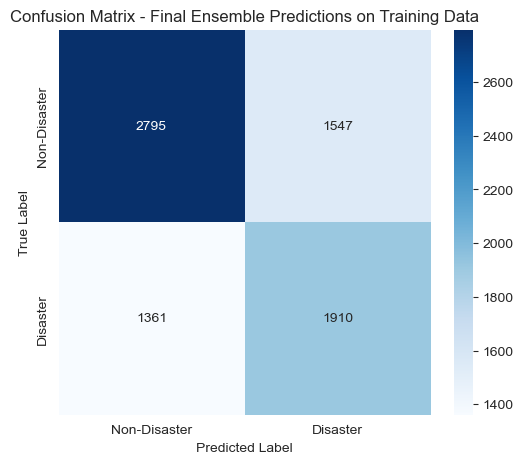

Final F1 score on training data: 0.5678

Final averaged probabilities on test data: [0.42941093 0.5735836  0.54374087 ... 0.59143257 0.57799828 0.46117741]
Final binary predictions on test data: [0 1 1 ... 1 1 0]

Final submission file saved as 'final_submission.csv'.


In [68]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from transformers import TFBertModel, BertTokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set random seeds for reproducibility
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(42)

# -------------------------
# Data Preparation using BERT Tokenizer
# -------------------------
# Assume tweets_data_train and tweets_data_test are your pandas DataFrames
# containing columns 'combined_text' and 'target' for training, and an 'id' column for test (if available).

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a maximum sequence length for BERT (e.g., 128 tokens)
max_length = 128

# Tokenize training and test texts with padding set to 'max_length'
train_texts = tweets_data_train['combined_text'].tolist()
test_texts = tweets_data_test['combined_text'].tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_length)

# Convert tokenized outputs to numpy arrays
train_input_ids = np.array(train_encodings['input_ids'])
train_attention_masks = np.array(train_encodings['attention_mask'])
test_input_ids = np.array(test_encodings['input_ids'])
test_attention_masks = np.array(test_encodings['attention_mask'])

# Compute class weights for imbalanced data
classes = np.unique(tweets_data_train['target'].values)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, 
                                     y=tweets_data_train['target'].values)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Computed class weights:", class_weight_dict)

# -------------------------
# Build BERT-Based Classification Model
# -------------------------
def build_final_model(max_length):
    # Define input layers for token IDs and attention masks
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    # Load the pre-trained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # Wrap the BERT call inside a Lambda layer to ensure inputs are concrete tensors
    def bert_call(inputs):
        input_ids, attention_mask = inputs
        input_ids = tf.cast(input_ids, tf.int32)
        attention_mask = tf.cast(attention_mask, tf.int32)
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        return outputs.pooler_output if hasattr(outputs, "pooler_output") else outputs[1]
    
    pooled_output = Lambda(bert_call, name="bert_layer")([input_ids, attention_mask])
    
    # Add dropout and a dense layer for binary classification
    x = Dropout(0.3)(pooled_output)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Define and compile the model
    model = Model(inputs=[input_ids, attention_mask], outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=2e-5),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

if __name__ == '__main__':
    # Build the model and print its summary
    model = build_final_model(max_length)
    model.summary()
    
    # -------------------------
    # Train the Final Model Multiple Times for Ensembling
    # -------------------------
    NUM_RUNS = 1
    FINAL_EPOCHS = 4  # Fine-tuning BERT typically requires fewer epochs
    train_preds_total = np.zeros((train_input_ids.shape[0], 1))
    test_preds_total = np.zeros((test_input_ids.shape[0], 1))

    for run in range(NUM_RUNS):
        print(f"\n--- Final Model Run {run+1}/{NUM_RUNS} ---")
        model = build_final_model(max_length)
        
        model.fit([train_input_ids, train_attention_masks],
                  tweets_data_train['target'].values,
                  epochs=FINAL_EPOCHS,
                  batch_size=16,  # Smaller batch size for BERT fine-tuning
                  class_weight=class_weight_dict,
                  verbose=1)
        
        run_train_preds = model.predict([train_input_ids, train_attention_masks])
        run_test_preds = model.predict([test_input_ids, test_attention_masks])
        
        train_preds_total += run_train_preds
        test_preds_total += run_test_preds

    train_preds_avg = train_preds_total / NUM_RUNS
    test_preds_avg = test_preds_total / NUM_RUNS

    final_train_labels = (train_preds_avg > 0.5).astype(int)
    final_test_labels = (test_preds_avg > 0.5).astype(int)

    # -------------------------
    # Evaluation on Training Data
    # -------------------------
    conf_matrix_train = confusion_matrix(tweets_data_train['target'].values, final_train_labels.flatten())

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Disaster", "Disaster"], 
                yticklabels=["Non-Disaster", "Disaster"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Final Ensemble Predictions on Training Data")
    plt.show()

    final_f1_train = f1_score(tweets_data_train['target'].values, final_train_labels.flatten())
    print(f"Final F1 score on training data: {final_f1_train:.4f}")

    print("\nFinal averaged probabilities on test data:", test_preds_avg.flatten())
    print("Final binary predictions on test data:", final_test_labels.flatten())

    # -------------------------
    # Create Submission File
    # -------------------------
    submission = pd.DataFrame({
        "id": tweets_data_test['id'] if 'id' in tweets_data_test.columns else range(len(tweets_data_test)),
        "target": final_test_labels.flatten()
    })
    submission.to_csv("final_submission.csv", index=False)
    print("\nFinal submission file saved as 'final_submission.csv'.")

In [ ]:
##############################################################################################################################